In [3]:
import yfinance as yf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from tda_m2r import *
import pandas as pd
from ripser import ripser, Rips
import persim
import gudhi
import requests
from datetime import datetime, timedelta

In [4]:
# Collecting sufficient amount of tickers

# Disable SSL verification (not recommended for production)
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url, verify=False)  # Disable SSL verification
    tables = pd.read_html(response.text)
    sp500_tickers = tables[0]['Symbol'].tolist()
    return sp500_tickers

def get_russell1000_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_Russell_1000_companies'
    response = requests.get(url, verify=False)  # Disable SSL verification
    tables = pd.read_html(response.text)
    russell1000_tickers = tables[0]['Ticker'].tolist()
    return russell1000_tickers

def get_nasdaq_tickers():
    url = 'https://en.wikipedia.org/wiki/NASDAQ-100'
    response = requests.get(url, verify=False)  # Disable SSL verification
    tables = pd.read_html(response.text)
    nasdaq_tickers = tables[4]['Ticker'].tolist()
    return nasdaq_tickers

def get_dow_tickers():
    url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
    response = requests.get(url, verify=False)  # Disable SSL verification
    tables = pd.read_html(response.text)
    dow_tickers = tables[1]['Symbol'].tolist()
    return dow_tickers

# Fetch tickers from different sources
sp500_tickers = get_sp500_tickers()
nasdaq_tickers = get_nasdaq_tickers()
dow_tickers = get_dow_tickers()

# Combine and deduplicate tickers
all_tickers = list(set(sp500_tickers + nasdaq_tickers + dow_tickers))

# Select 200 unique tickers
selected_tickers = all_tickers[:500]

# Display the total number of unique tickers and the selected tickers
print(f"Total unique tickers: {len(selected_tickers)}")



/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_15890/472908719.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)
/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_15890/472908719.py:23: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


Total unique tickers: 500


/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_15890/472908719.py:30: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [5]:
#download tickers from above
data = yf.download(selected_tickers, start='2015-01-01', end='2021-12-31')

# Ensure the 'Date' column is a datetime type and set it as the index
data.index = pd.to_datetime(data.index)

data.head(5)
# Only need the adjusted close price for each ticker
data = data['Adj Close']

# Checking if the data frame is correctly set up.
data.head(5)


[***************       31%%                      ]  156 of 500 completed

$BF.B: possibly delisted; No price data found  (1d 2015-01-01 -> 2021-12-31)


[*********************100%%**********************]  500 of 500 completed

8 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2015-01-01 -> 2021-12-31)')
['KVUE', 'VLTO', 'GEV', 'SOLV', 'CEG', 'GEHC']: YFChartError("%ticker%: Data doesn't exist for startDate = 1420088400, endDate = 1640926800")
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.551189,51.079922,24.402172,44.314442,NaN,37.481438,19.496668,75.950912,72.339996,45.454937,...,101.781891,24.597061,127.992783,27.094418,61.023270,43.460007,101.607880,77.430000,NaN,40.470413
2015-01-05,36.847565,51.051487,23.714720,43.480476,NaN,37.489777,19.379999,74.668533,71.980003,44.628330,...,101.050819,24.597061,125.814362,26.786865,59.353565,42.576996,105.398201,76.339996,NaN,40.227463
2015-01-06,36.273567,50.255585,23.716955,43.265259,NaN,37.064045,19.423332,74.129944,70.529999,43.580753,...,100.548180,24.569807,123.130592,26.929390,59.038033,42.054382,104.504776,75.790001,NaN,39.834988
2015-01-07,36.754978,50.227158,24.049519,45.013905,NaN,37.364552,19.536667,75.685898,71.110001,44.039062,...,101.987511,24.644732,126.746681,27.161934,59.636250,43.448002,107.103851,77.720001,NaN,40.657291
2015-01-08,37.856705,50.843029,24.973557,45.484669,NaN,38.132553,19.876667,76.840019,72.919998,44.816563,...,103.152695,24.910395,128.271591,27.476984,60.628868,44.204865,108.240944,79.379997,NaN,41.283371


In [6]:
# Only include tickers that is already in the market start

# Selecting tickers that have market value on the first trading day of 2015
filter = [not pd.isna(value) for value in data.loc['2015-01-02']]

# Filtered out the unwanted tickers
df = data.loc[:, filter]

# we end up having 434 tickers

In [7]:
df.head(5)

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.551189,51.079922,24.402172,44.314442,37.481438,19.496668,75.950912,72.339996,45.454937,39.839649,...,49.964741,101.781891,24.597061,127.992783,27.094418,61.023270,43.460007,101.607880,77.430000,40.470413
2015-01-05,36.847565,51.051487,23.714720,43.480476,37.489777,19.379999,74.668533,71.980003,44.628330,38.461109,...,49.275066,101.050819,24.597061,125.814362,26.786865,59.353565,42.576996,105.398201,76.339996,40.227463
2015-01-06,36.273567,50.255585,23.716955,43.265259,37.064045,19.423332,74.129944,70.529999,43.580753,37.702927,...,48.432087,100.548180,24.569807,123.130592,26.929390,59.038033,42.054382,104.504776,75.790001,39.834988
2015-01-07,36.754978,50.227158,24.049519,45.013905,37.364552,19.536667,75.685898,71.110001,44.039062,38.269650,...,49.217590,101.987511,24.644732,126.746681,27.161934,59.636250,43.448002,107.103851,77.720001,40.657291
2015-01-08,37.856705,50.843029,24.973557,45.484669,38.132553,19.876667,76.840019,72.919998,44.816563,37.710579,...,50.185078,103.152695,24.910395,128.271591,27.476984,60.628868,44.204865,108.240944,79.379997,41.283371


In [8]:
for x in df:
    # z-score normalisation of for each column using sample standard deviation
    df[x] = (df[x] - df[x].mean()) / np.std(df[x], ddof= len(df[x]) - 119)

    # Smoothing using 15-days window
    df[x] = df[x].rolling(window=15, center=True).mean()

    # converting daily stock prices to derivatives
    df[x] = df[x] - df[x].shift(1)

# remove rows of NaN 
df = df.dropna()

/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_15890/3083268441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = (df[x] - df[x].mean()) / np.std(df[x], ddof= len(df[x]) - 119)
/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_15890/3083268441.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = df[x].rolling(window=15, center=True).mean()
/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_15890/3083268441.py:9: SettingWithCopyWarning: 
A value is trying to be s

/Users/cm/Documents/Python/2nd_Year/M2R/tda/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


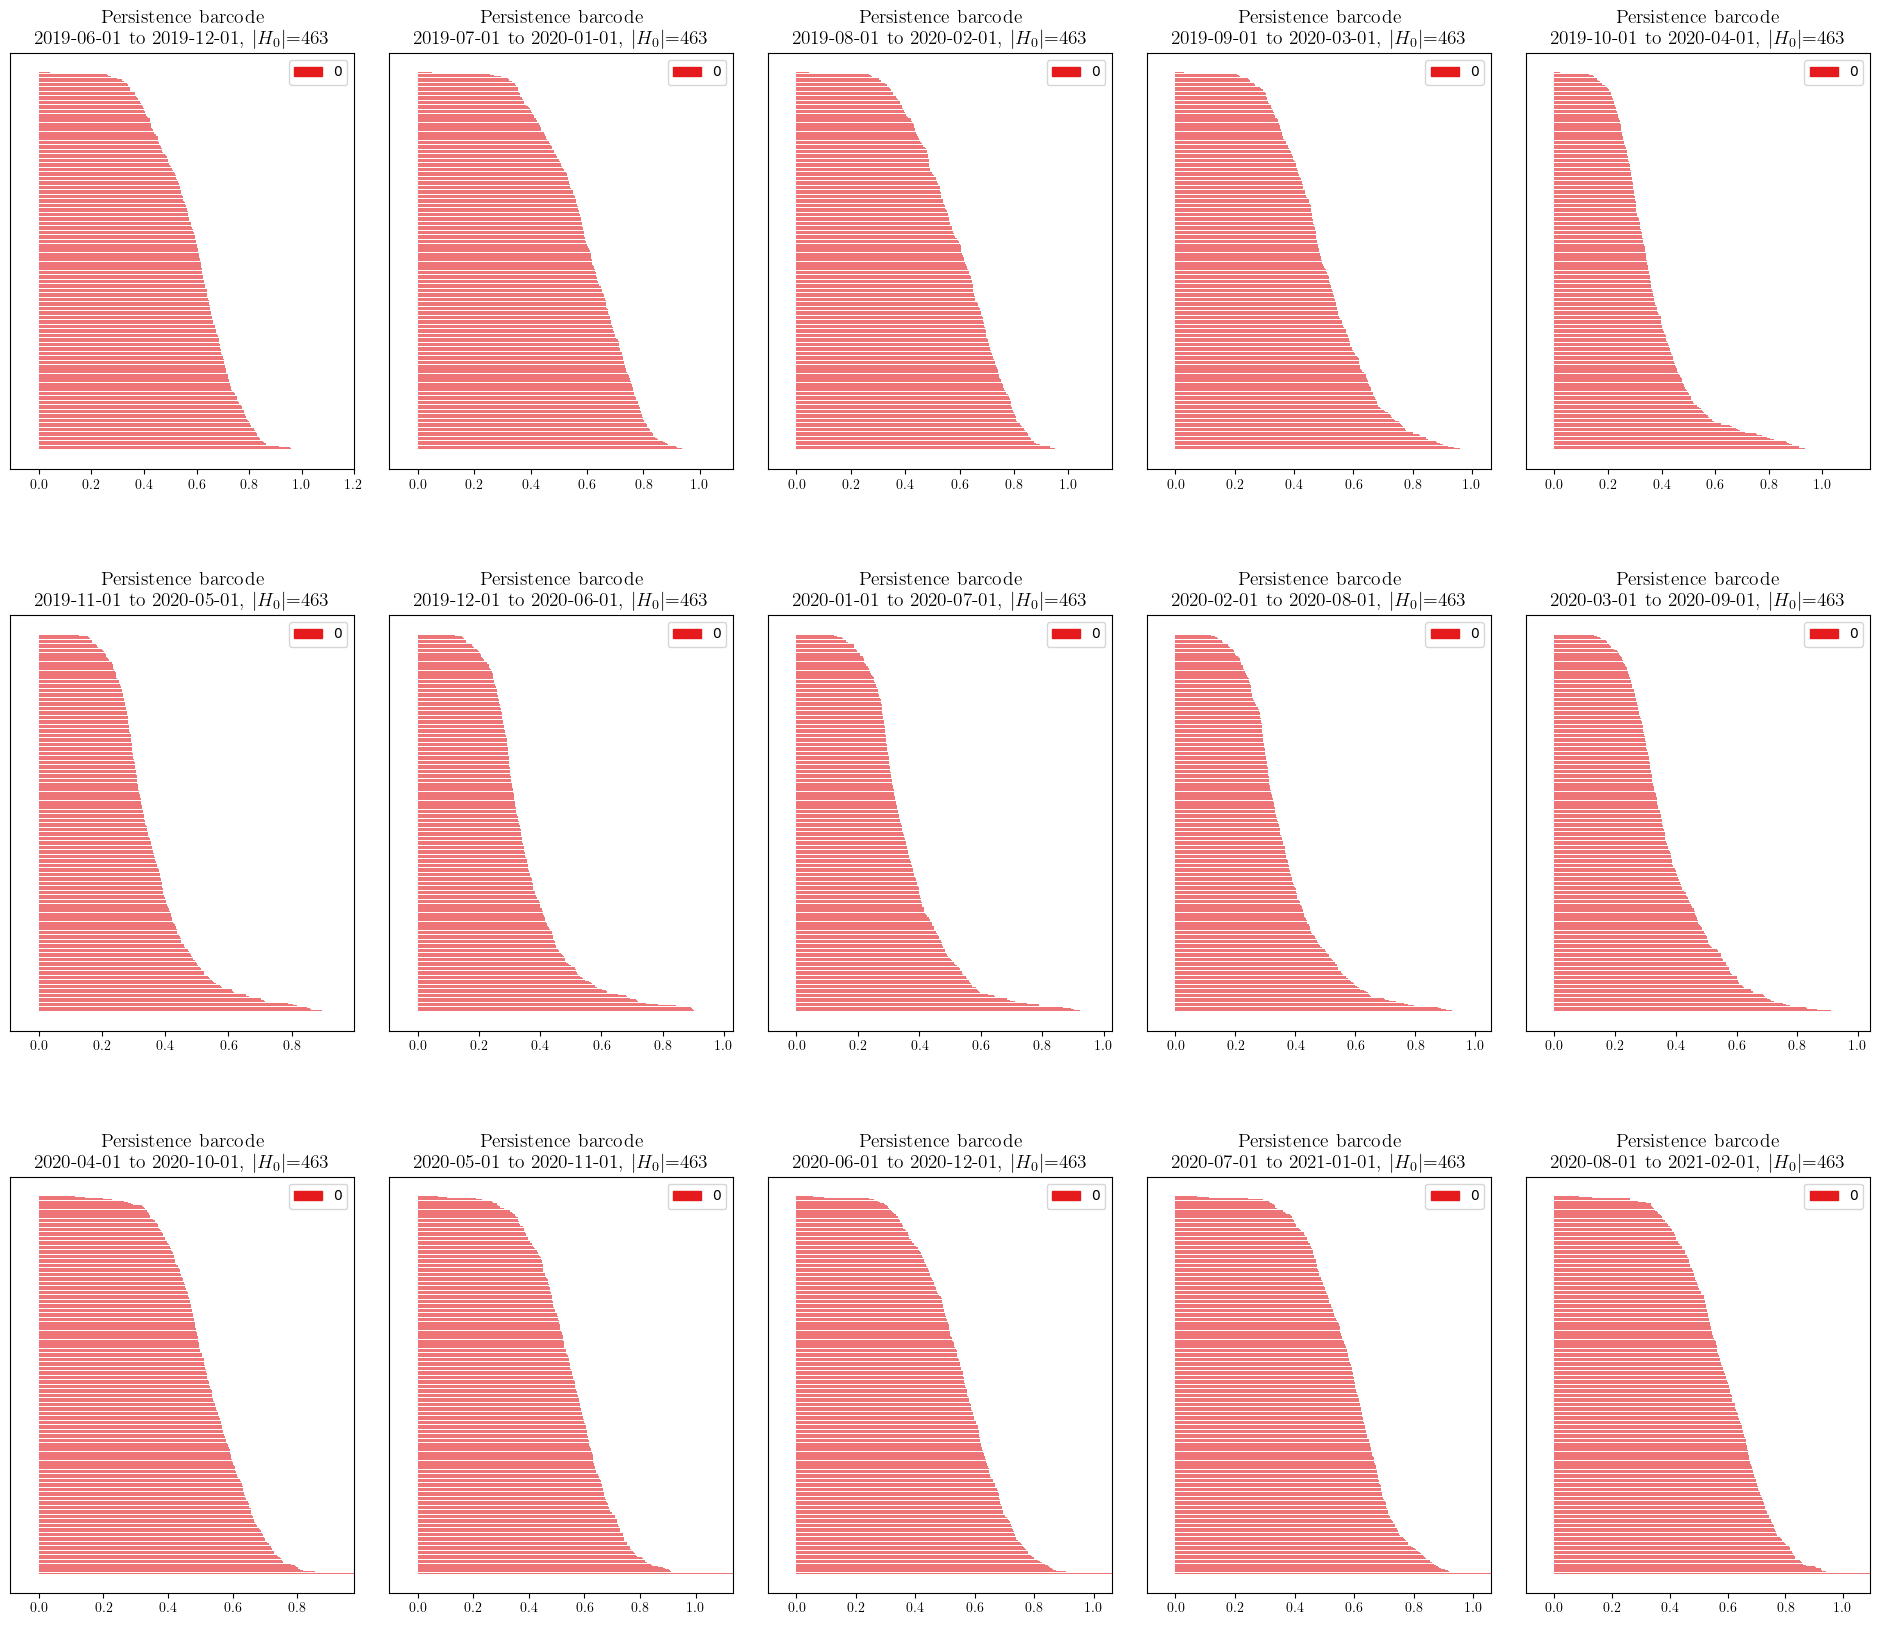

In [9]:
start_date_string = "2019-06-01"
period = 6
number_of_period = 15
subplot_row = 3
subplot_columns = 5
dim = 0


start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

start_dates = [start_date + pd.DateOffset(months=i) for i in range(number_of_period)]

fig, axs = plt.subplots(subplot_row, subplot_columns, figsize=(24, 20))

count = 0

for start_date in start_dates:
    end_date = start_date + pd.DateOffset(months=period)

    data_6months = df[start_date:end_date]

    # computing correlation matrix of the 6 months period
    data_6months_corr = data_6months.corr()
    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']
    gd_barcode(barcode[dim], dim=dim, axes=axs[count//subplot_columns, count % subplot_columns])

    axs[count//subplot_columns, count % subplot_columns].set_title(f"Persistence barcode \n {str(start_date).split()[0]} to {str(end_date).split()[0]}, $|H_{dim}|$={len(barcode[dim])}", fontsize = 14)
    
    count += 1
    plt.subplots_adjust(hspace=0.35)
    plt.subplots_adjust(wspace=0.1)


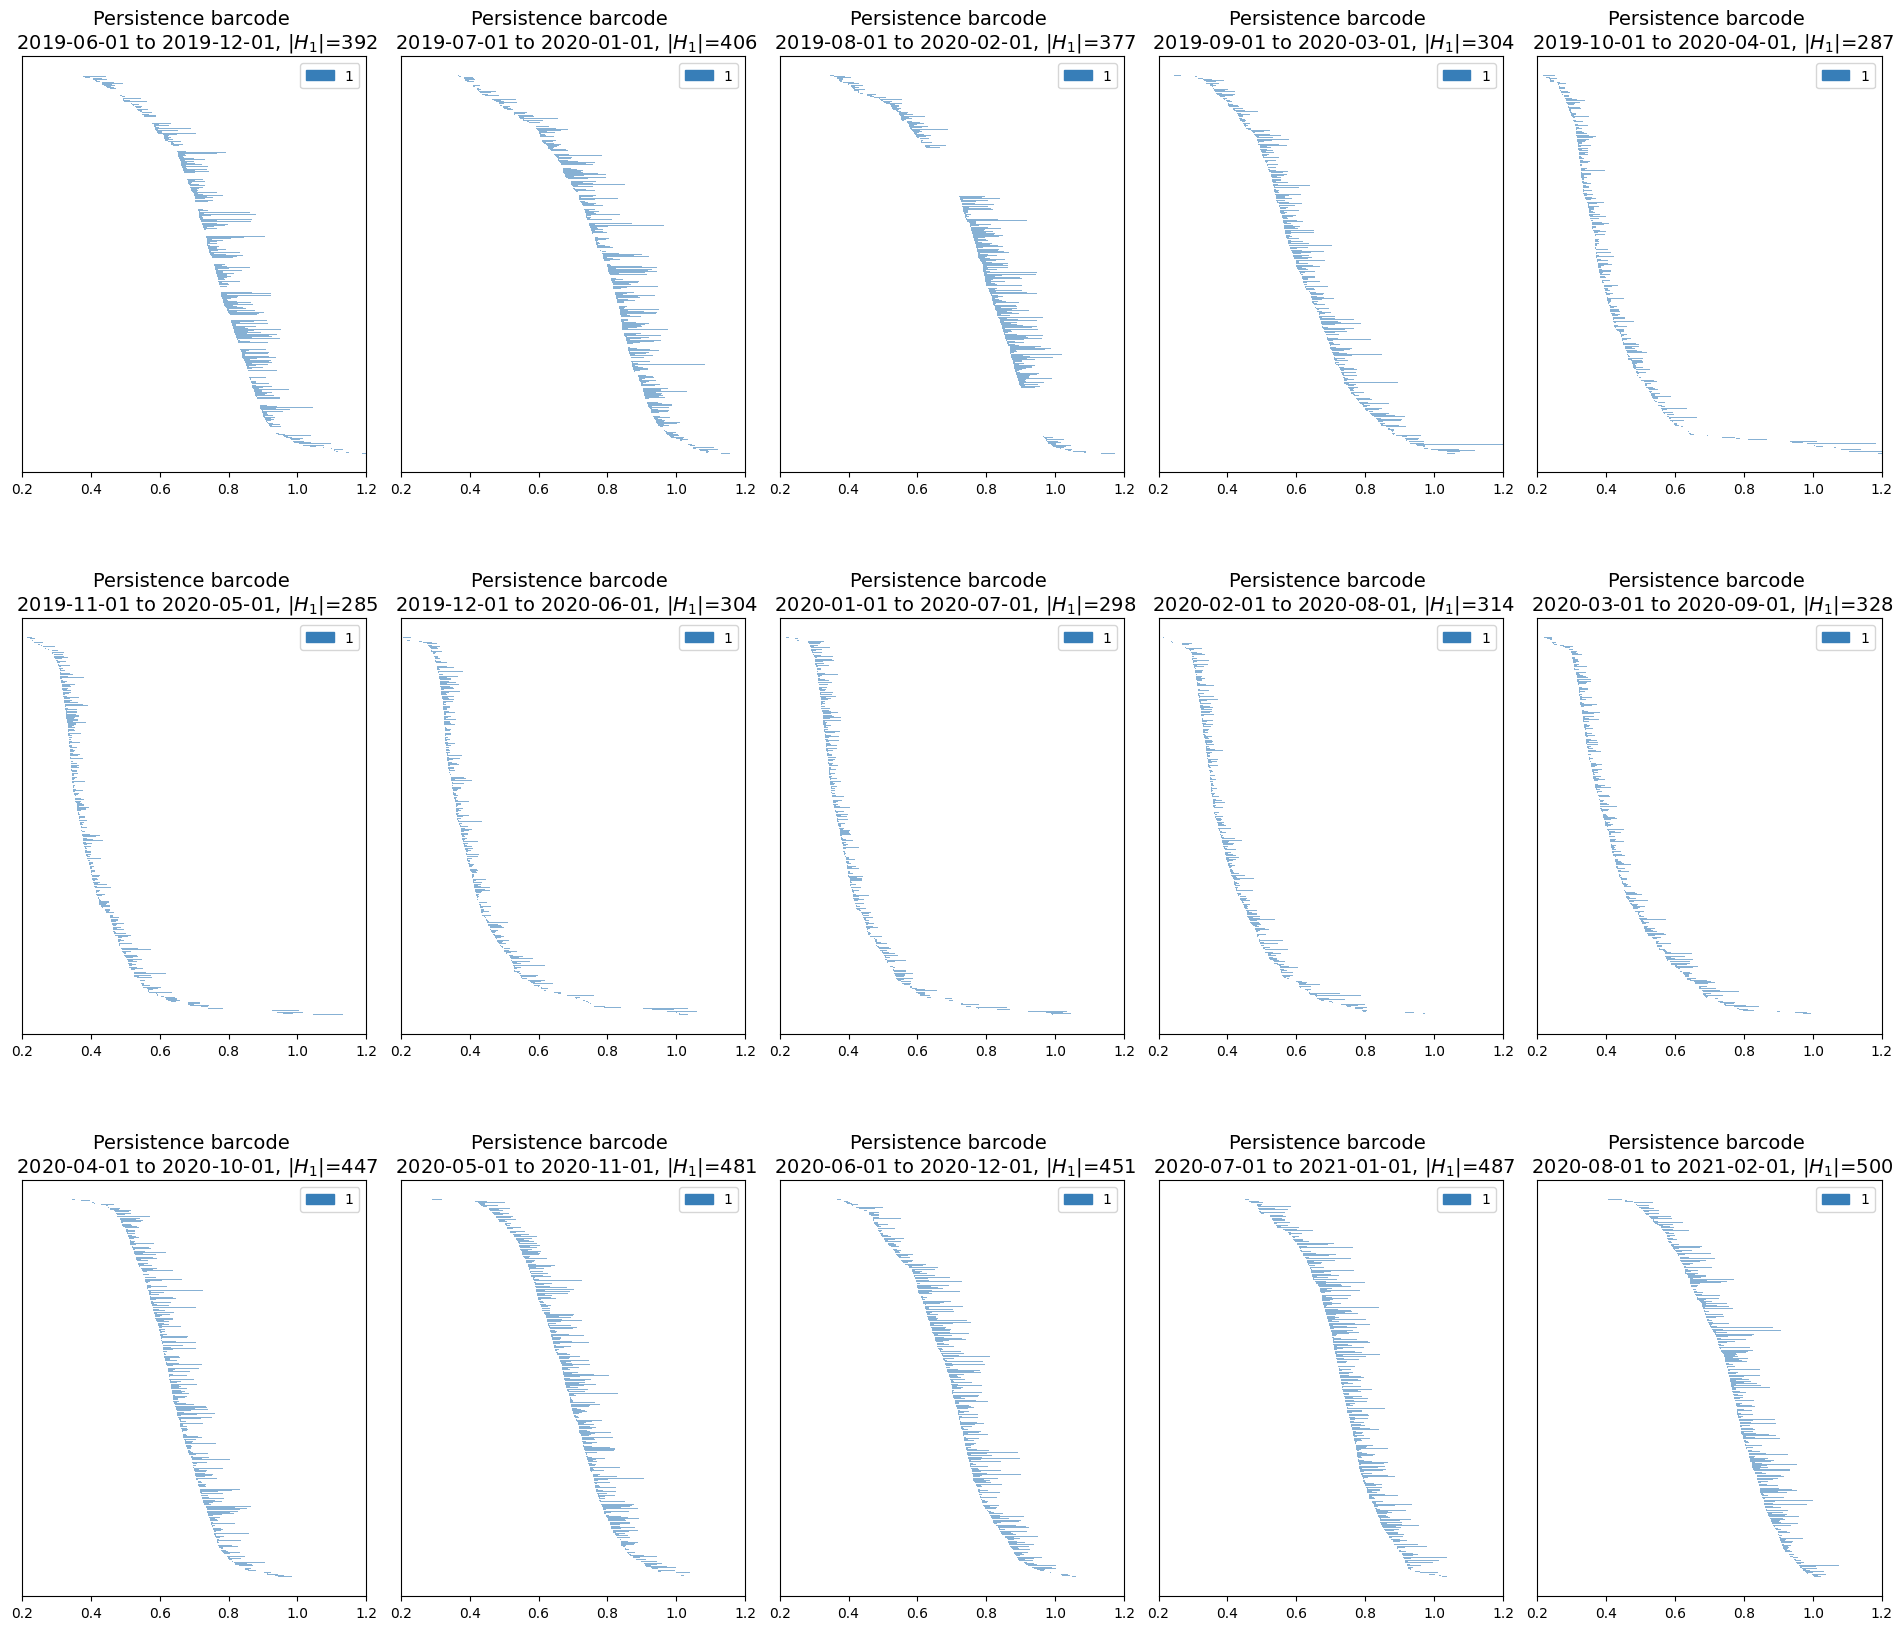

In [10]:
start_date_string = "2019-06-01"
period = 6
number_of_period = 15
subplot_row = 3
subplot_columns = 5
dim = 1


start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

start_dates = [start_date + pd.DateOffset(months=i) for i in range(number_of_period)]

fig, axs = plt.subplots(subplot_row, subplot_columns, figsize=(24, 20))

count = 0

for start_date in start_dates:
    end_date = start_date + pd.DateOffset(months=period)

    data_6months = df[start_date:end_date]

    # computing correlation matrix of the 6 months period
    data_6months_corr = data_6months.corr()
    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']
    gd_barcode(barcode[dim], dim=dim, axes=axs[count//subplot_columns, count % subplot_columns])

    axs[count//subplot_columns, count % subplot_columns].set_xlim(0.2, 1.2)
    axs[count//subplot_columns, count % subplot_columns].set_title(f"Persistence barcode \n {str(start_date).split()[0]} to {str(end_date).split()[0]}, $|H_{dim}|$={len(barcode[dim])}", fontsize = 14)
    
    count += 1
    plt.subplots_adjust(hspace=0.35)
    plt.subplots_adjust(wspace=0.1)


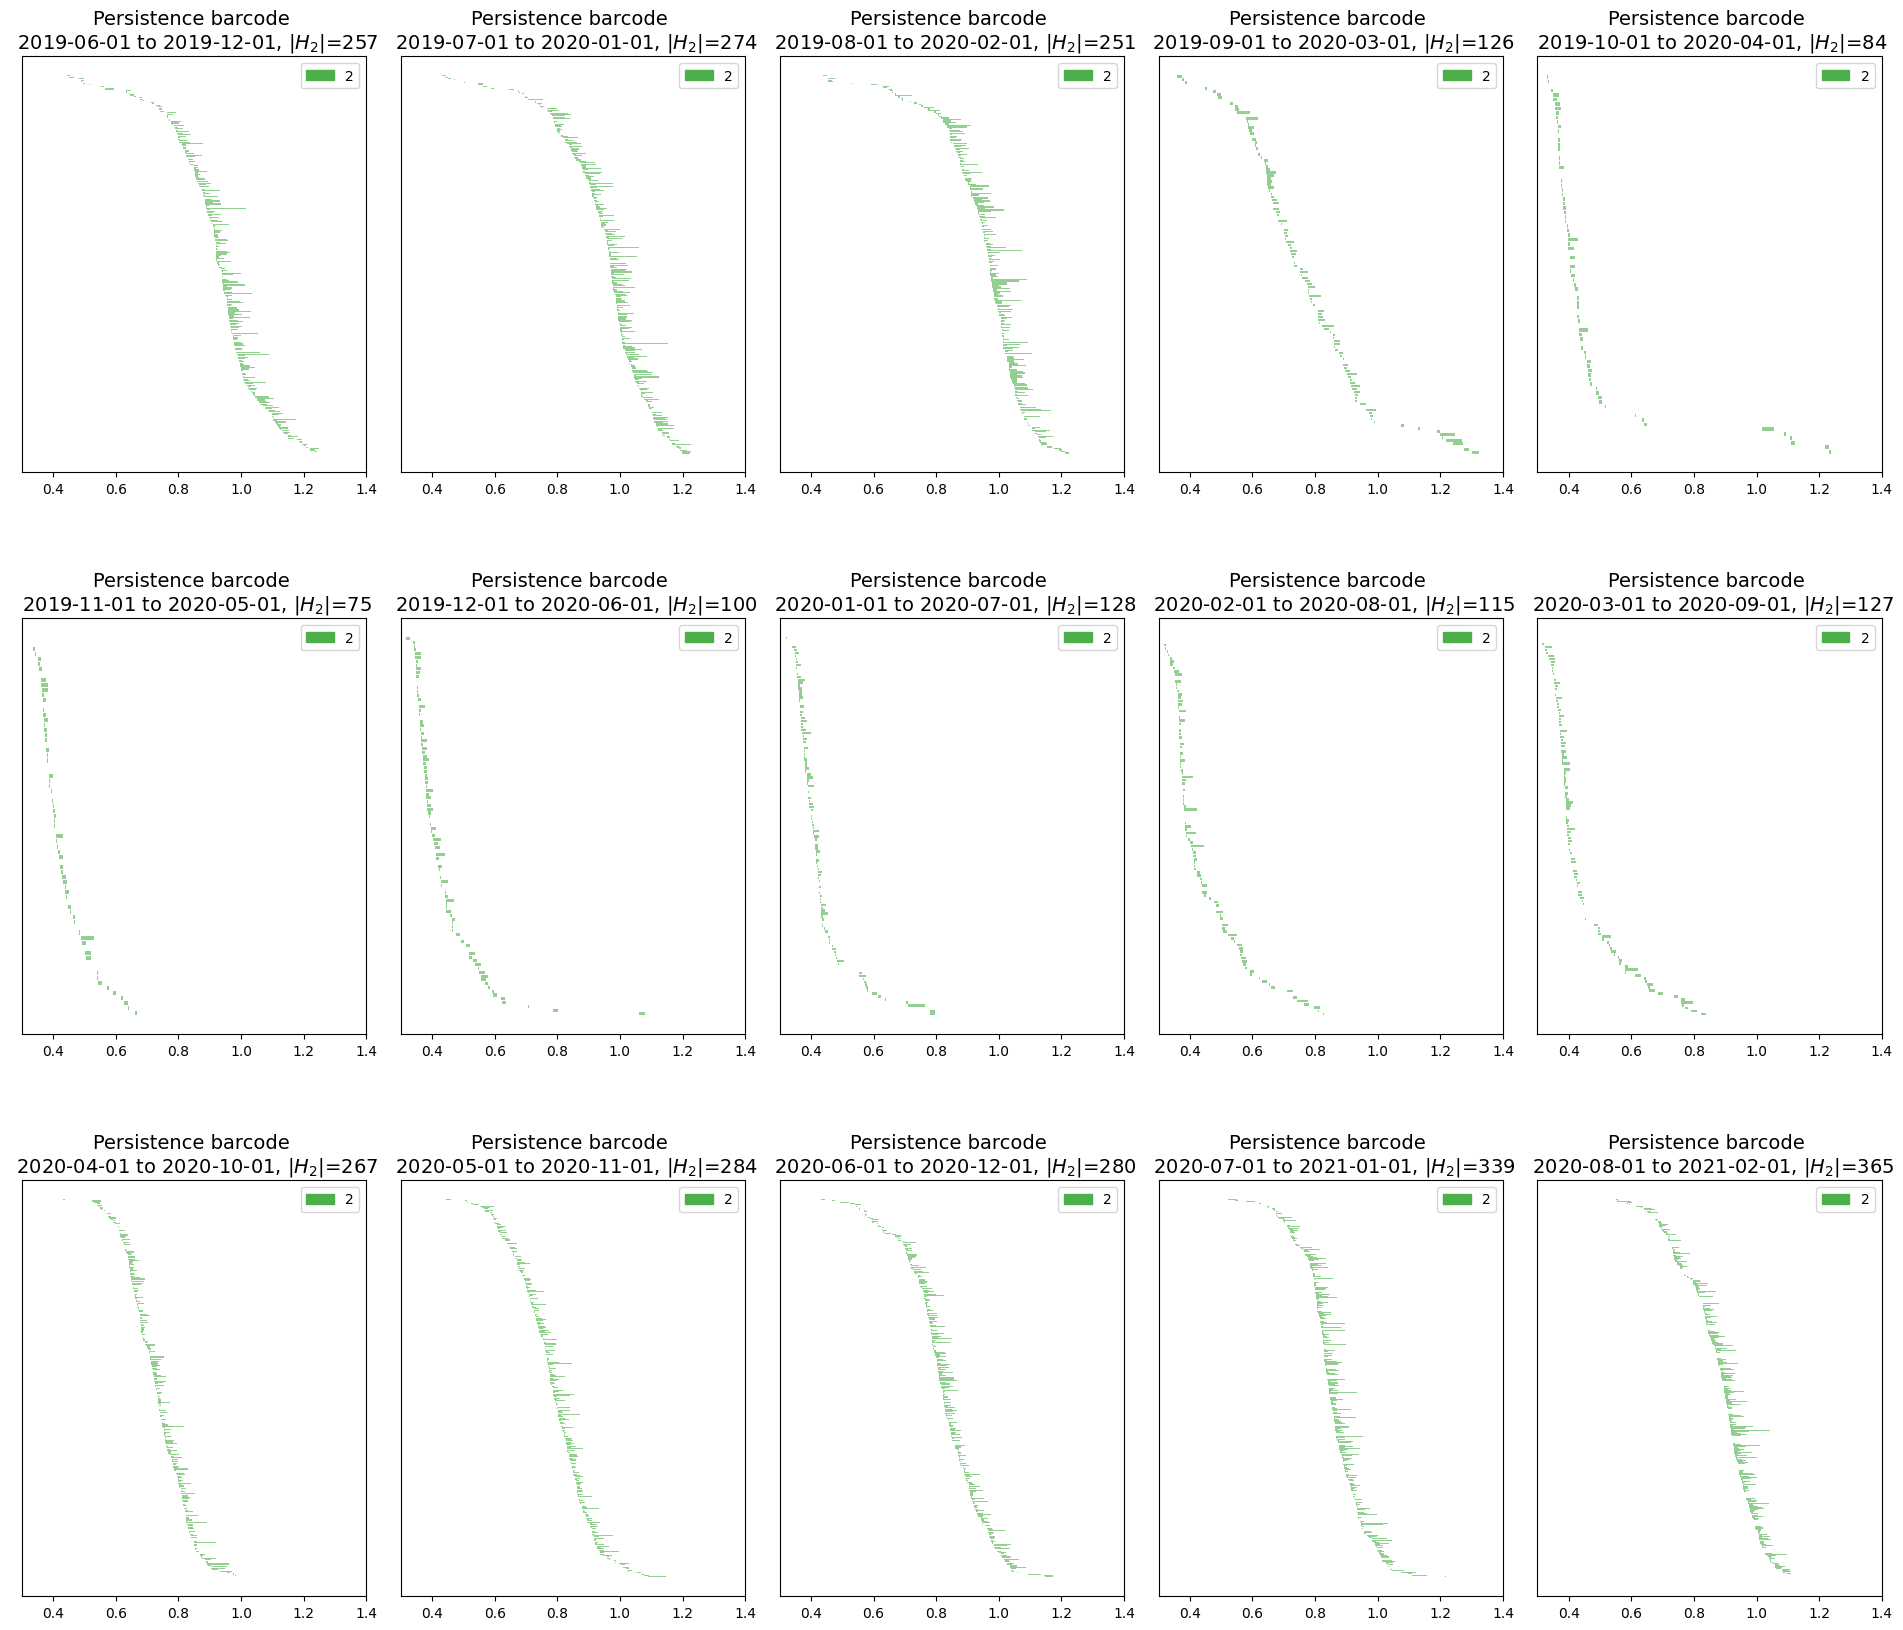

In [11]:

start_date_string = "2019-06-01"
period = 6
number_of_period = 15
subplot_row = 3
subplot_columns = 5
dim = 2


start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

start_dates = [start_date + pd.DateOffset(months=i) for i in range(number_of_period)]

fig, axs = plt.subplots(subplot_row, subplot_columns, figsize=(24, 20))

count = 0

for start_date in start_dates:
    end_date = start_date + pd.DateOffset(months=period)

    data_6months = df[start_date:end_date]

    # computing correlation matrix of the 6 months period
    data_6months_corr = data_6months.corr()
    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']
    gd_barcode(barcode[dim], dim=dim, axes=axs[count//subplot_columns, count % subplot_columns])

    axs[count//subplot_columns, count % subplot_columns].set_xlim(0.3, 1.4)
    axs[count//subplot_columns, count % subplot_columns].set_title(f"Persistence barcode \n {str(start_date).split()[0]} to {str(end_date).split()[0]}, $|H_{dim}|$={len(barcode[dim])}", fontsize = 14)
    
    count += 1
    plt.subplots_adjust(hspace=0.35)
    plt.subplots_adjust(wspace=0.1)


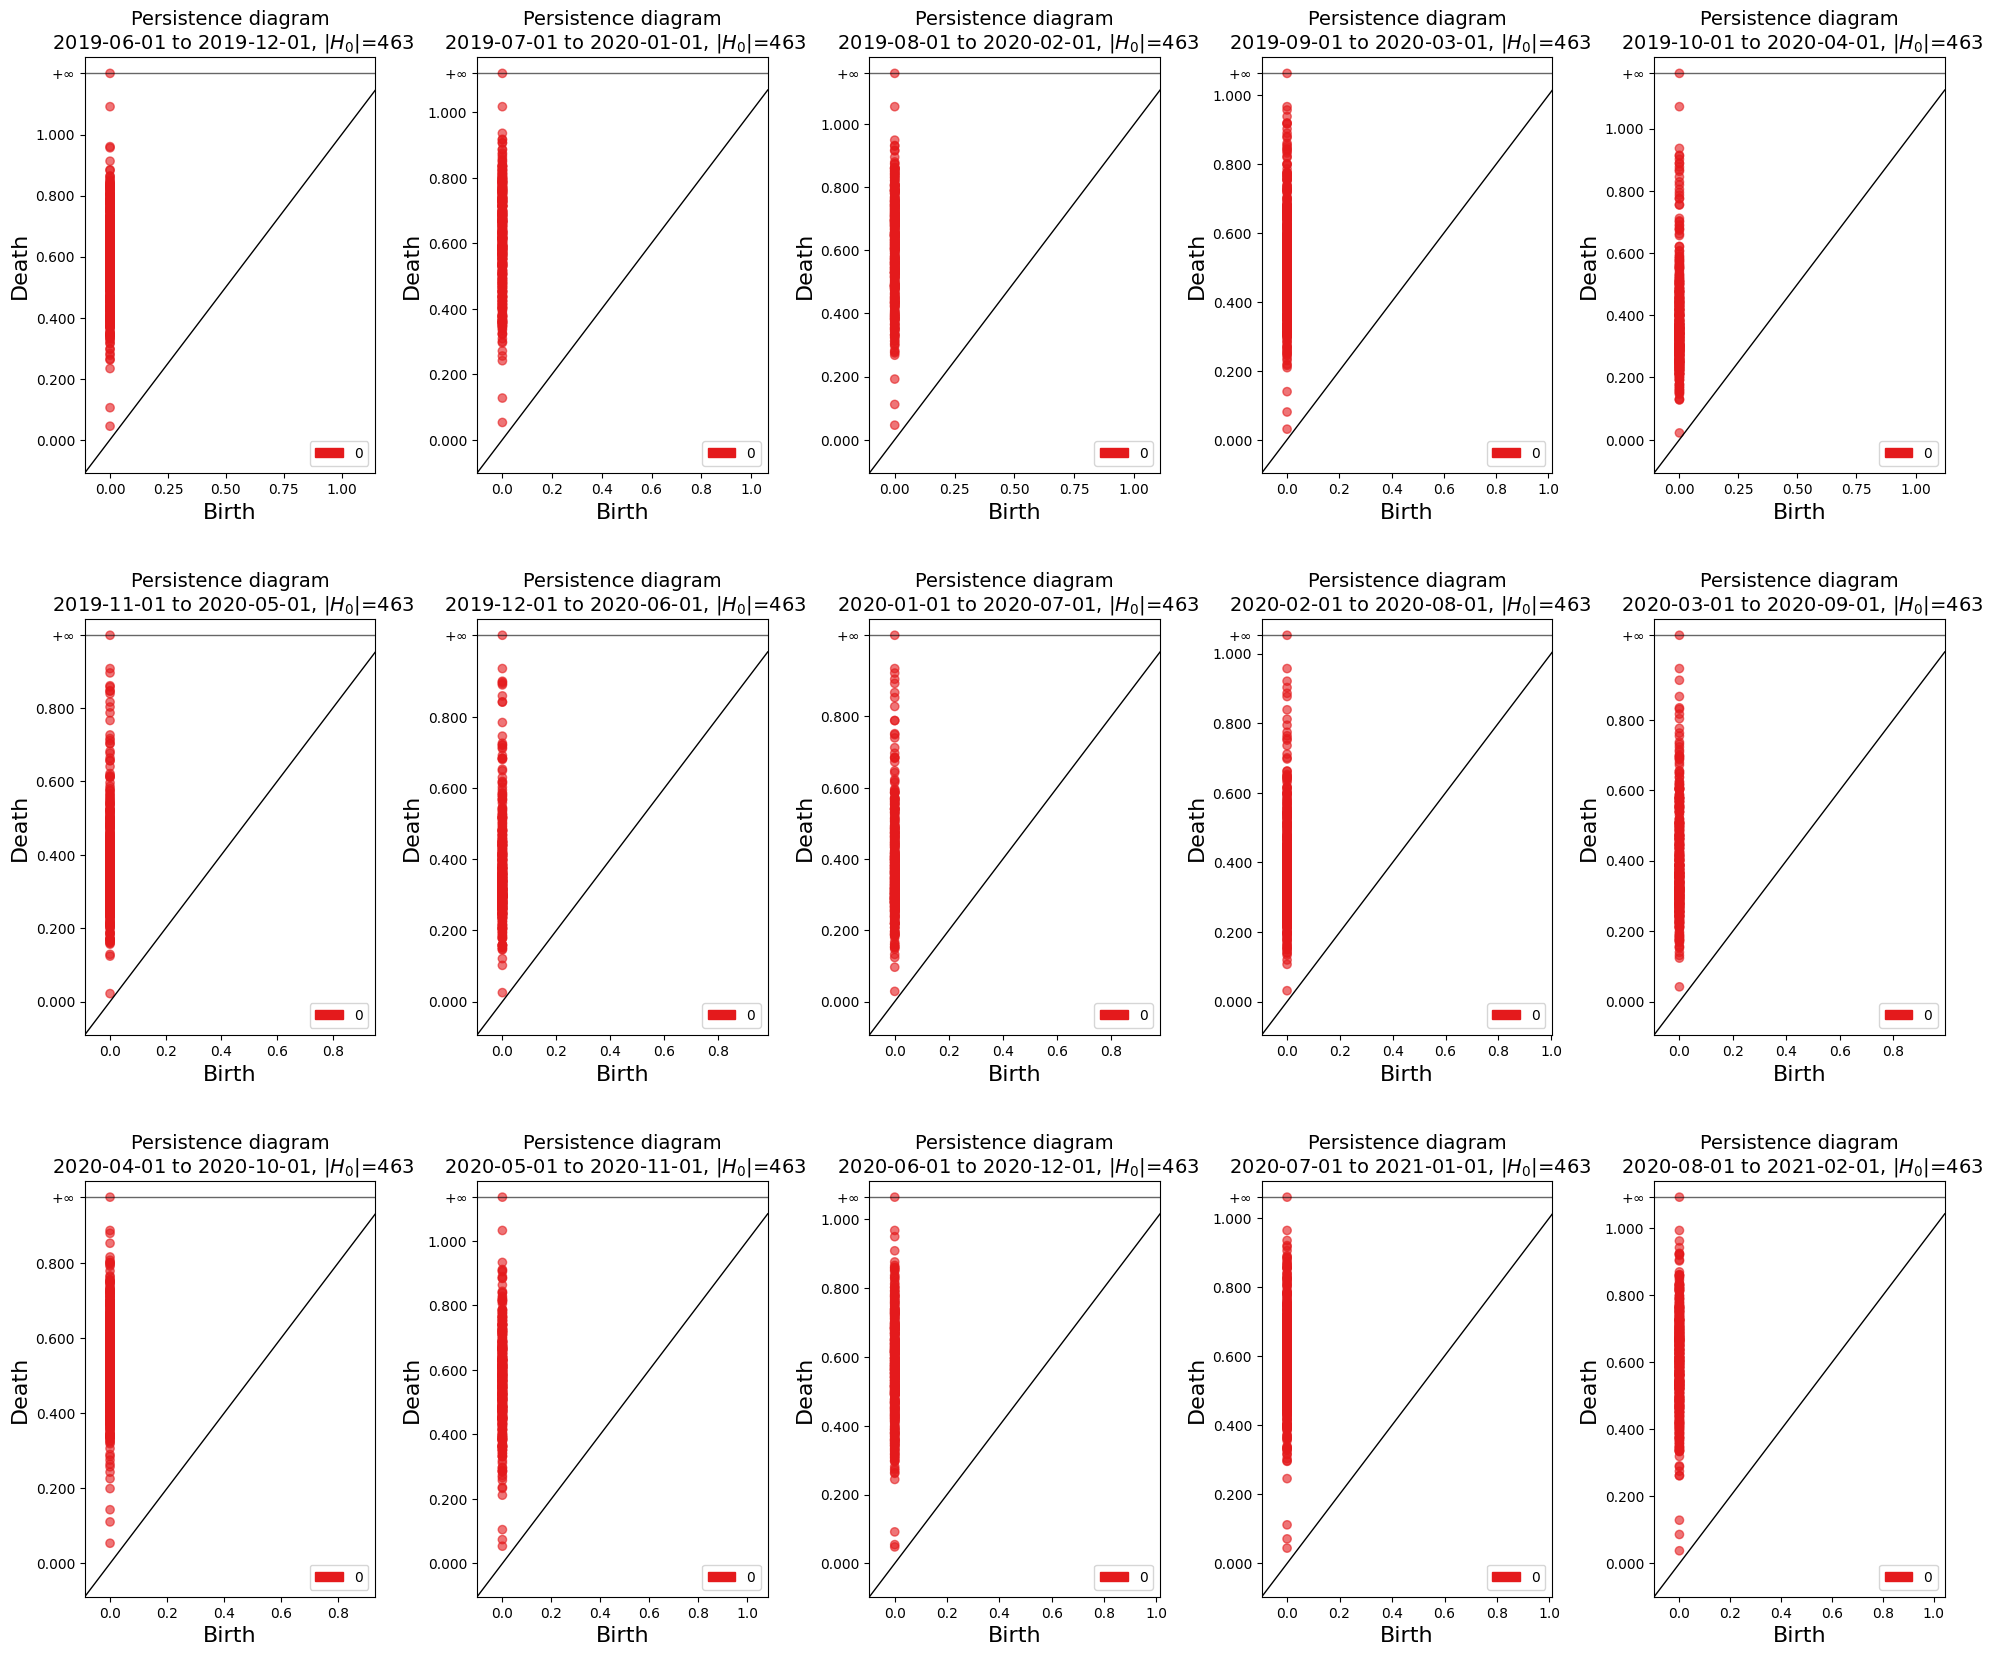

In [12]:

start_date_string = "2019-06-01"
period = 6
number_of_period = 15
subplot_row = 3
subplot_columns = 5
dim = 0


start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

start_dates = [start_date + pd.DateOffset(months=i) for i in range(number_of_period)]

fig, axs = plt.subplots(subplot_row, subplot_columns, figsize=(24, 20))

count = 0

for start_date in start_dates:
    end_date = start_date + pd.DateOffset(months=period)

    data_6months = df[start_date:end_date]

    # computing correlation matrix of the 6 months period
    data_6months_corr = data_6months.corr()
    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']
    gd_persistence(barcode[dim], dim=dim, axes=axs[count//subplot_columns, count % subplot_columns])

    axs[count//subplot_columns, count % subplot_columns].set_title(f"Persistence diagram\n {str(start_date).split()[0]} to {str(end_date).split()[0]}, $|H_{dim}|$={len(barcode[dim])}", fontsize = 14)
    
    count += 1
    plt.subplots_adjust(hspace=0.35)
    plt.subplots_adjust(wspace=0.35)


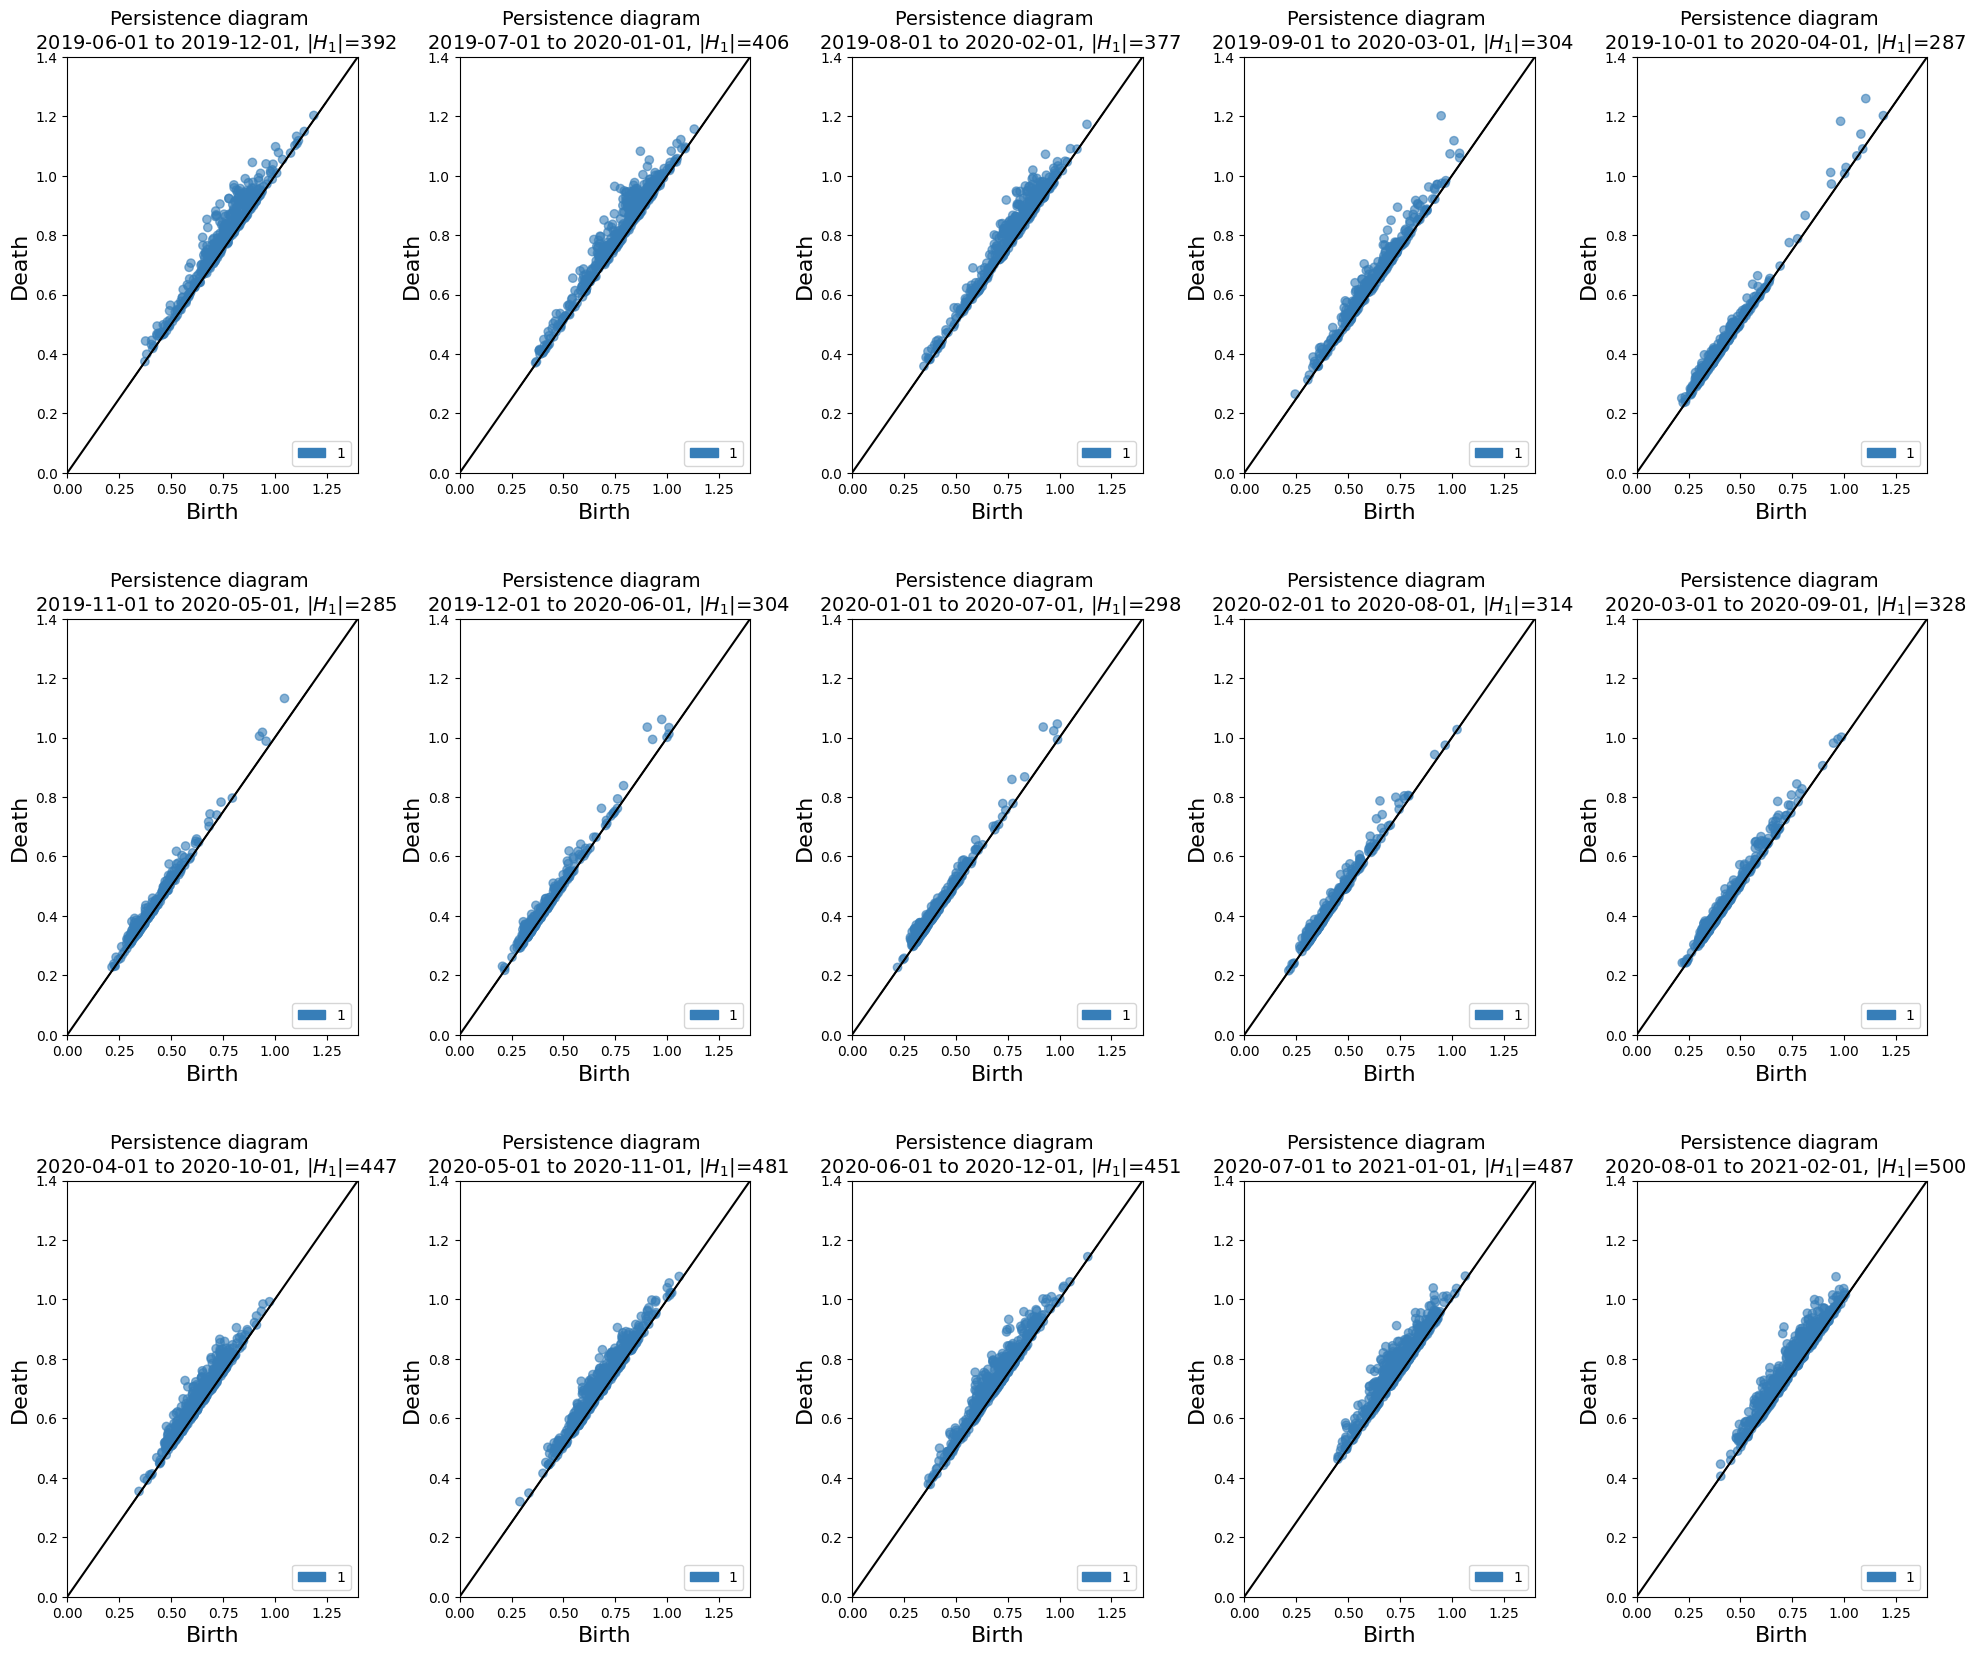

In [13]:

start_date_string = "2019-06-01"
period = 6
number_of_period = 15
subplot_row = 3
subplot_columns = 5
dim = 1


start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

start_dates = [start_date + pd.DateOffset(months=i) for i in range(number_of_period)]

fig, axs = plt.subplots(subplot_row, subplot_columns, figsize=(24, 20))

count = 0

for start_date in start_dates:
    end_date = start_date + pd.DateOffset(months=period)

    data_6months = df[start_date:end_date]

    # computing correlation matrix of the 6 months period
    data_6months_corr = data_6months.corr()
    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']
    gd_persistence(barcode[dim], dim=dim, axes=axs[count//subplot_columns, count % subplot_columns])

    axs[count//subplot_columns, count % subplot_columns].set_xlim(0, 1.4)
    axs[count//subplot_columns, count % subplot_columns].set_ylim(0, 1.4)
    axs[count//subplot_columns, count % subplot_columns].set_title(f"Persistence diagram \n {str(start_date).split()[0]} to {str(end_date).split()[0]}, $|H_{dim}|$={len(barcode[dim])}", fontsize = 14)

    x = np.linspace(0, 1.4, 100)
    y = x
    axs[count//subplot_columns, count % subplot_columns].plot(x, y, color='black')

    
    count += 1
    plt.subplots_adjust(hspace=0.35)
    plt.subplots_adjust(wspace=0.35)


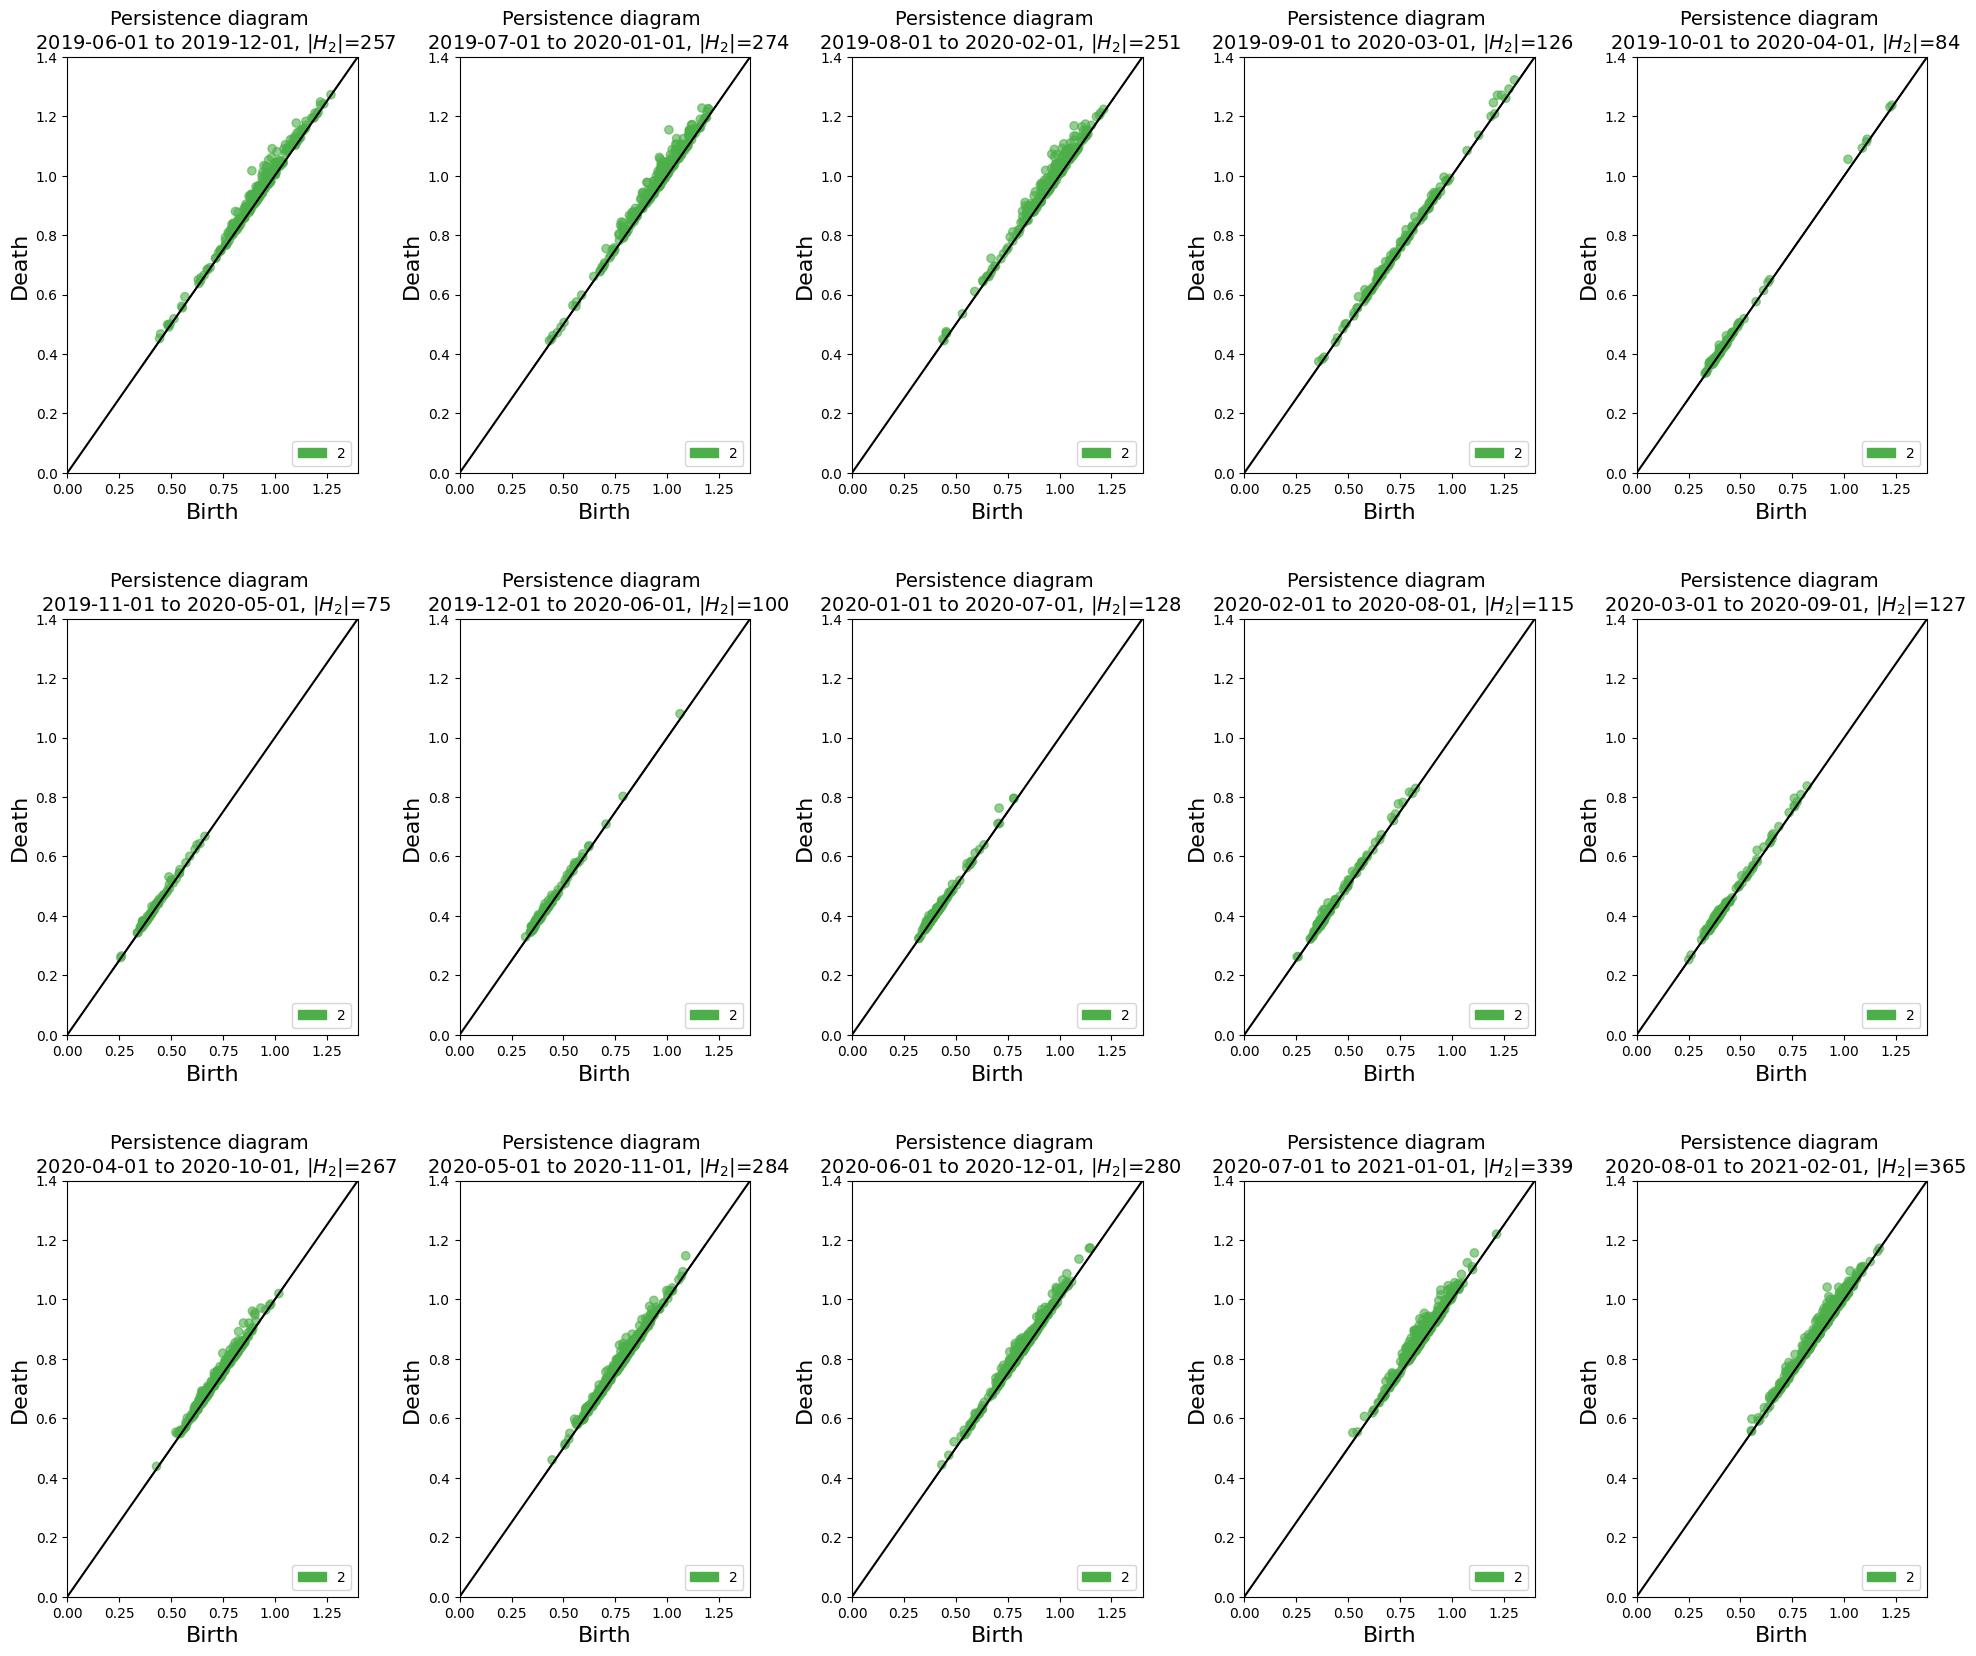

In [14]:

start_date_string = "2019-06-01"
period = 6
number_of_period = 15
subplot_row = 3
subplot_columns = 5
dim = 2


start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

start_dates = [start_date + pd.DateOffset(months=i) for i in range(number_of_period)]

fig, axs = plt.subplots(subplot_row, subplot_columns, figsize=(24, 20))

count = 0

for start_date in start_dates:
    end_date = start_date + pd.DateOffset(months=period)

    data_6months = df[start_date:end_date]

    # computing correlation matrix of the 6 months period
    data_6months_corr = data_6months.corr()
    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']
    gd_persistence(barcode[dim], dim=dim, axes=axs[count//subplot_columns, count % subplot_columns])

    axs[count//subplot_columns, count % subplot_columns].set_xlim(0, 1.4)
    axs[count//subplot_columns, count % subplot_columns].set_ylim(0, 1.4)
    axs[count//subplot_columns, count % subplot_columns].set_title(f"Persistence diagram \n {str(start_date).split()[0]} to {str(end_date).split()[0]}, $|H_{dim}|$={len(barcode[dim])}", fontsize = 14)

    x = np.linspace(0, 1.4, 100)
    y = x
    axs[count//subplot_columns, count % subplot_columns].plot(x, y, color='black')

    
    count += 1
    plt.subplots_adjust(hspace=0.35, wspace=0.35)


In [15]:
start_date_string = "2019-07-01"

period = 6

dim = 2

start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

end_date = start_date + pd.DateOffset(months=period)

data_6months = df[start_date:end_date]

data_6months_corr = data_6months.corr()
data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']

entropy_ls = []

for h in barcode:

    l = h[:,1] - h[:, 0]
    l = l[l != np.inf]
    Sl = sum(l)
    p = l / Sl
    lp = np.log(p)
    entropy_ls.append(-sum(p * lp))
    
entropy_ls

[6.104176013113478, 5.65799559702758, 5.251412932074254]

In [16]:
start_date_string = "2019-10-01"

period = 6

dim = 2

start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

end_date = start_date + pd.DateOffset(months=period)

data_6months = df[start_date:end_date]

data_6months_corr = data_6months.corr()

data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']

entropy_ls = []

for h in barcode:

    l = h[:,1] - h[:, 0]
    l = l[l != np.inf]
    Sl = sum(l)
    p = l / Sl
    lp = np.log(p)
    entropy_ls.append(-sum(p * lp))
    
entropy_ls

[6.063672370919943, 5.219184549658905, 4.073321813393105]

In [39]:
import pandas as pd

# Generate a range of dates from a start date with a monthly frequency
first_period_month = '2019-06-01'
last_period_month = '2020-08-01'

consec_month = pd.date_range(start=first_period_month, end=last_period_month, freq='MS')

periods_tuple = [(date, date + pd.DateOffset(months=6)) for date in consec_month]

# Generate 6-month periods for each date in the range
periods_index = [f"{period[0].strftime('%Y-%m-%d')} to {period[1].strftime('%Y-%m-%d')}" for period in periods_tuple]

# Create the DataFrame
df_entropy = pd.DataFrame(index=periods_index)

df_entropy.index.name = 'Period'

entropy_arr = np.zeros((len(df_entropy), 3))

for i, period in enumerate(periods_tuple):

    data_6months = df[period[0]:period[1]]

    data_6months_corr = data_6months.corr()

    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']

    for j, h in enumerate(barcode):
        
        l = h[:,1] - h[:, 0]
        l = l[l != np.inf]
        Sl = sum(l)
        p = l / Sl
        lp = np.log(p)
        entropy_arr[i][j] = -sum(p * lp)



print(entropy_arr)

[[6.10475511 5.57157799 5.1838596 ]
 [6.10417601 5.6579956  5.25141293]
 [6.10114837 5.58409574 5.14655486]
 [6.09103138 5.34268625 4.48287337]
 [6.06367237 5.21918455 4.07332181]
 [6.07754735 5.28910208 3.93164561]
 [6.0742719  5.30475186 4.32686855]
 [6.07567041 5.3213823  4.46319827]
 [6.07135293 5.35559806 4.38456067]
 [6.07251898 5.41691189 4.49649699]
 [6.10773205 5.72686143 5.20190864]
 [6.10370641 5.86133432 5.28610293]
 [6.10239055 5.74402065 5.31148522]
 [6.10805488 5.84810165 5.44332512]
 [6.10514116 5.86543352 5.56262754]]


In [40]:
df_entropy[f"$E\\left(H_0^{{(\\bullet)}}\\right)$"] = entropy_arr[:, 0]
df_entropy[f"$E\\left(H_1^{{(\\bullet)}}\\right)$"]= entropy_arr[:, 1]
df_entropy[f"$E\\left(H_2^{{(\\bullet)}}\\right)$"]= entropy_arr[:, 2]
df_entropy

,$E\left(H_0^{(\bullet)}\right)$,$E\left(H_1^{(\bullet)}\right)$,$E\left(H_2^{(\bullet)}\right)$
Period,,,
2019-06-01 to 2019-12-01,6.104755,5.571578,5.183860
2019-07-01 to 2020-01-01,6.104176,5.657996,5.251413
2019-08-01 to 2020-02-01,6.101148,5.584096,5.146555
2019-09-01 to 2020-03-01,6.091031,5.342686,4.482873
2019-10-01 to 2020-04-01,6.063672,5.219185,4.073322
2019-11-01 to 2020-05-01,6.077547,5.289102,3.931646
2019-12-01 to 2020-06-01,6.074272,5.304752,4.326869
2020-01-01 to 2020-07-01,6.075670,5.321382,4.463198
2020-02-01 to 2020-08-01,6.071353,5.355598,4.384561


In [34]:
print(df_entropy.to_latex())

\begin{tabular}{lrrr}
\toprule
 & $H_0^{(\bullet)}$ & $H_1^{(\bullet)}$ & $H_2^{(\bullet)}$ \\
Period &  &  &  \\
\midrule
2019-06-01 to 2019-12-01 & 6.104755 & 5.571578 & 5.183860 \\
2019-07-01 to 2020-01-01 & 6.104176 & 5.657996 & 5.251413 \\
2019-08-01 to 2020-02-01 & 6.101148 & 5.584096 & 5.146555 \\
2019-09-01 to 2020-03-01 & 6.091031 & 5.342686 & 4.482873 \\
2019-10-01 to 2020-04-01 & 6.063672 & 5.219185 & 4.073322 \\
2019-11-01 to 2020-05-01 & 6.077547 & 5.289102 & 3.931646 \\
2019-12-01 to 2020-06-01 & 6.074272 & 5.304752 & 4.326869 \\
2020-01-01 to 2020-07-01 & 6.075670 & 5.321382 & 4.463198 \\
2020-02-01 to 2020-08-01 & 6.071353 & 5.355598 & 4.384561 \\
2020-03-01 to 2020-09-01 & 6.072519 & 5.416912 & 4.496497 \\
2020-04-01 to 2020-10-01 & 6.107732 & 5.726861 & 5.201909 \\
2020-05-01 to 2020-11-01 & 6.103706 & 5.861334 & 5.286103 \\
2020-06-01 to 2020-12-01 & 6.102391 & 5.744021 & 5.311485 \\
2020-07-01 to 2021-01-01 & 6.108055 & 5.848102 & 5.443325 \\
2020-08-01 to 2021-02-0

In [41]:
for x in df_entropy:
    print(x)

$E\left(H_0^{(\bullet)}\right)$
$E\left(H_1^{(\bullet)}\right)$
$E\left(H_2^{(\bullet)}\right)$


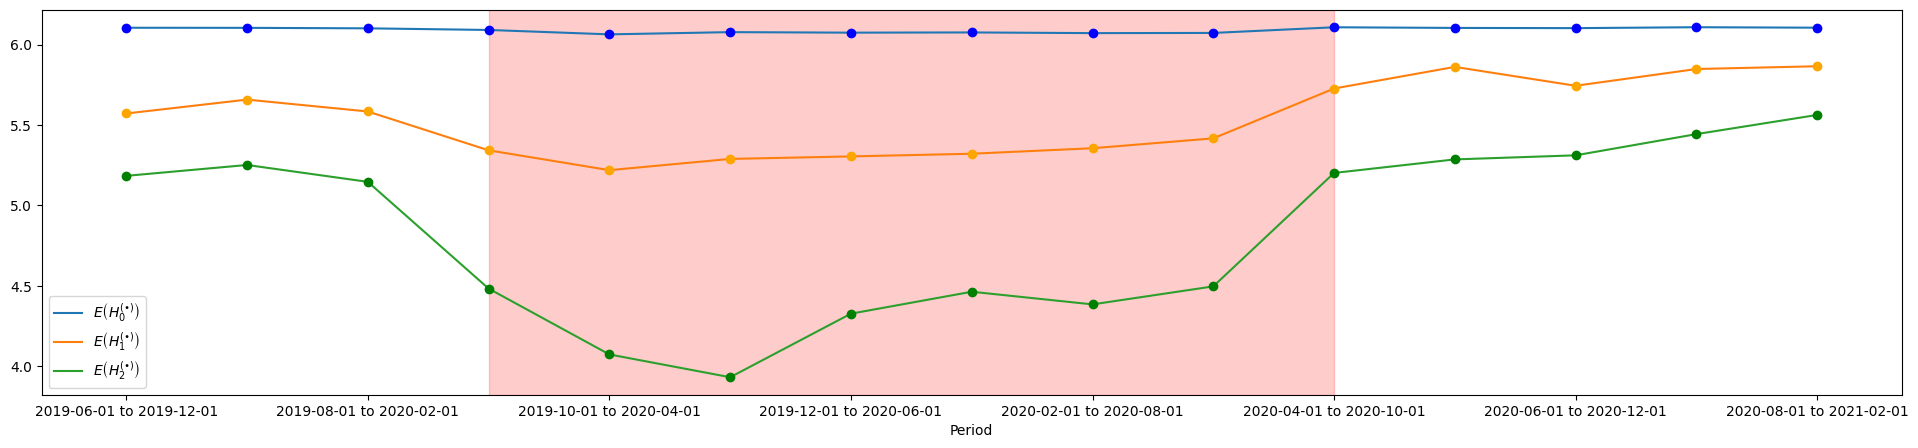

In [44]:
ax = df_entropy.plot(figsize=(24,5))

#ax.axvspan(4, 10, color='yellow', alpha=0.3)
ax.axvspan(3, 10, color='red', alpha=0.2)
ax.plot(df_entropy.index, df_entropy['$E\\left(H_0^{(\\bullet)}\\right)$'], 'o', color='blue')
ax.plot(df_entropy.index, df_entropy['$E\\left(H_1^{(\\bullet)}\\right)$'], 'o', color='orange')
ax.plot(df_entropy.index, df_entropy['$E\\left(H_2^{(\\bullet)}\\right)$'], 'o', color='green')

In [23]:
df_entropy['$\\beta_0$']

Period
2019-06-01 to 2019-12-01    6.104755
2019-07-01 to 2020-01-01    6.104176
2019-08-01 to 2020-02-01    6.101148
2019-09-01 to 2020-03-01    6.091031
2019-10-01 to 2020-04-01    6.063672
2019-11-01 to 2020-05-01    6.077547
2019-12-01 to 2020-06-01    6.074272
2020-01-01 to 2020-07-01    6.075670
2020-02-01 to 2020-08-01    6.071353
2020-03-01 to 2020-09-01    6.072519
2020-04-01 to 2020-10-01    6.107732
2020-05-01 to 2020-11-01    6.103706
2020-06-01 to 2020-12-01    6.102391
2020-07-01 to 2021-01-01    6.108055
2020-08-01 to 2021-02-01    6.105141
Name: $\beta_0$, dtype: float64

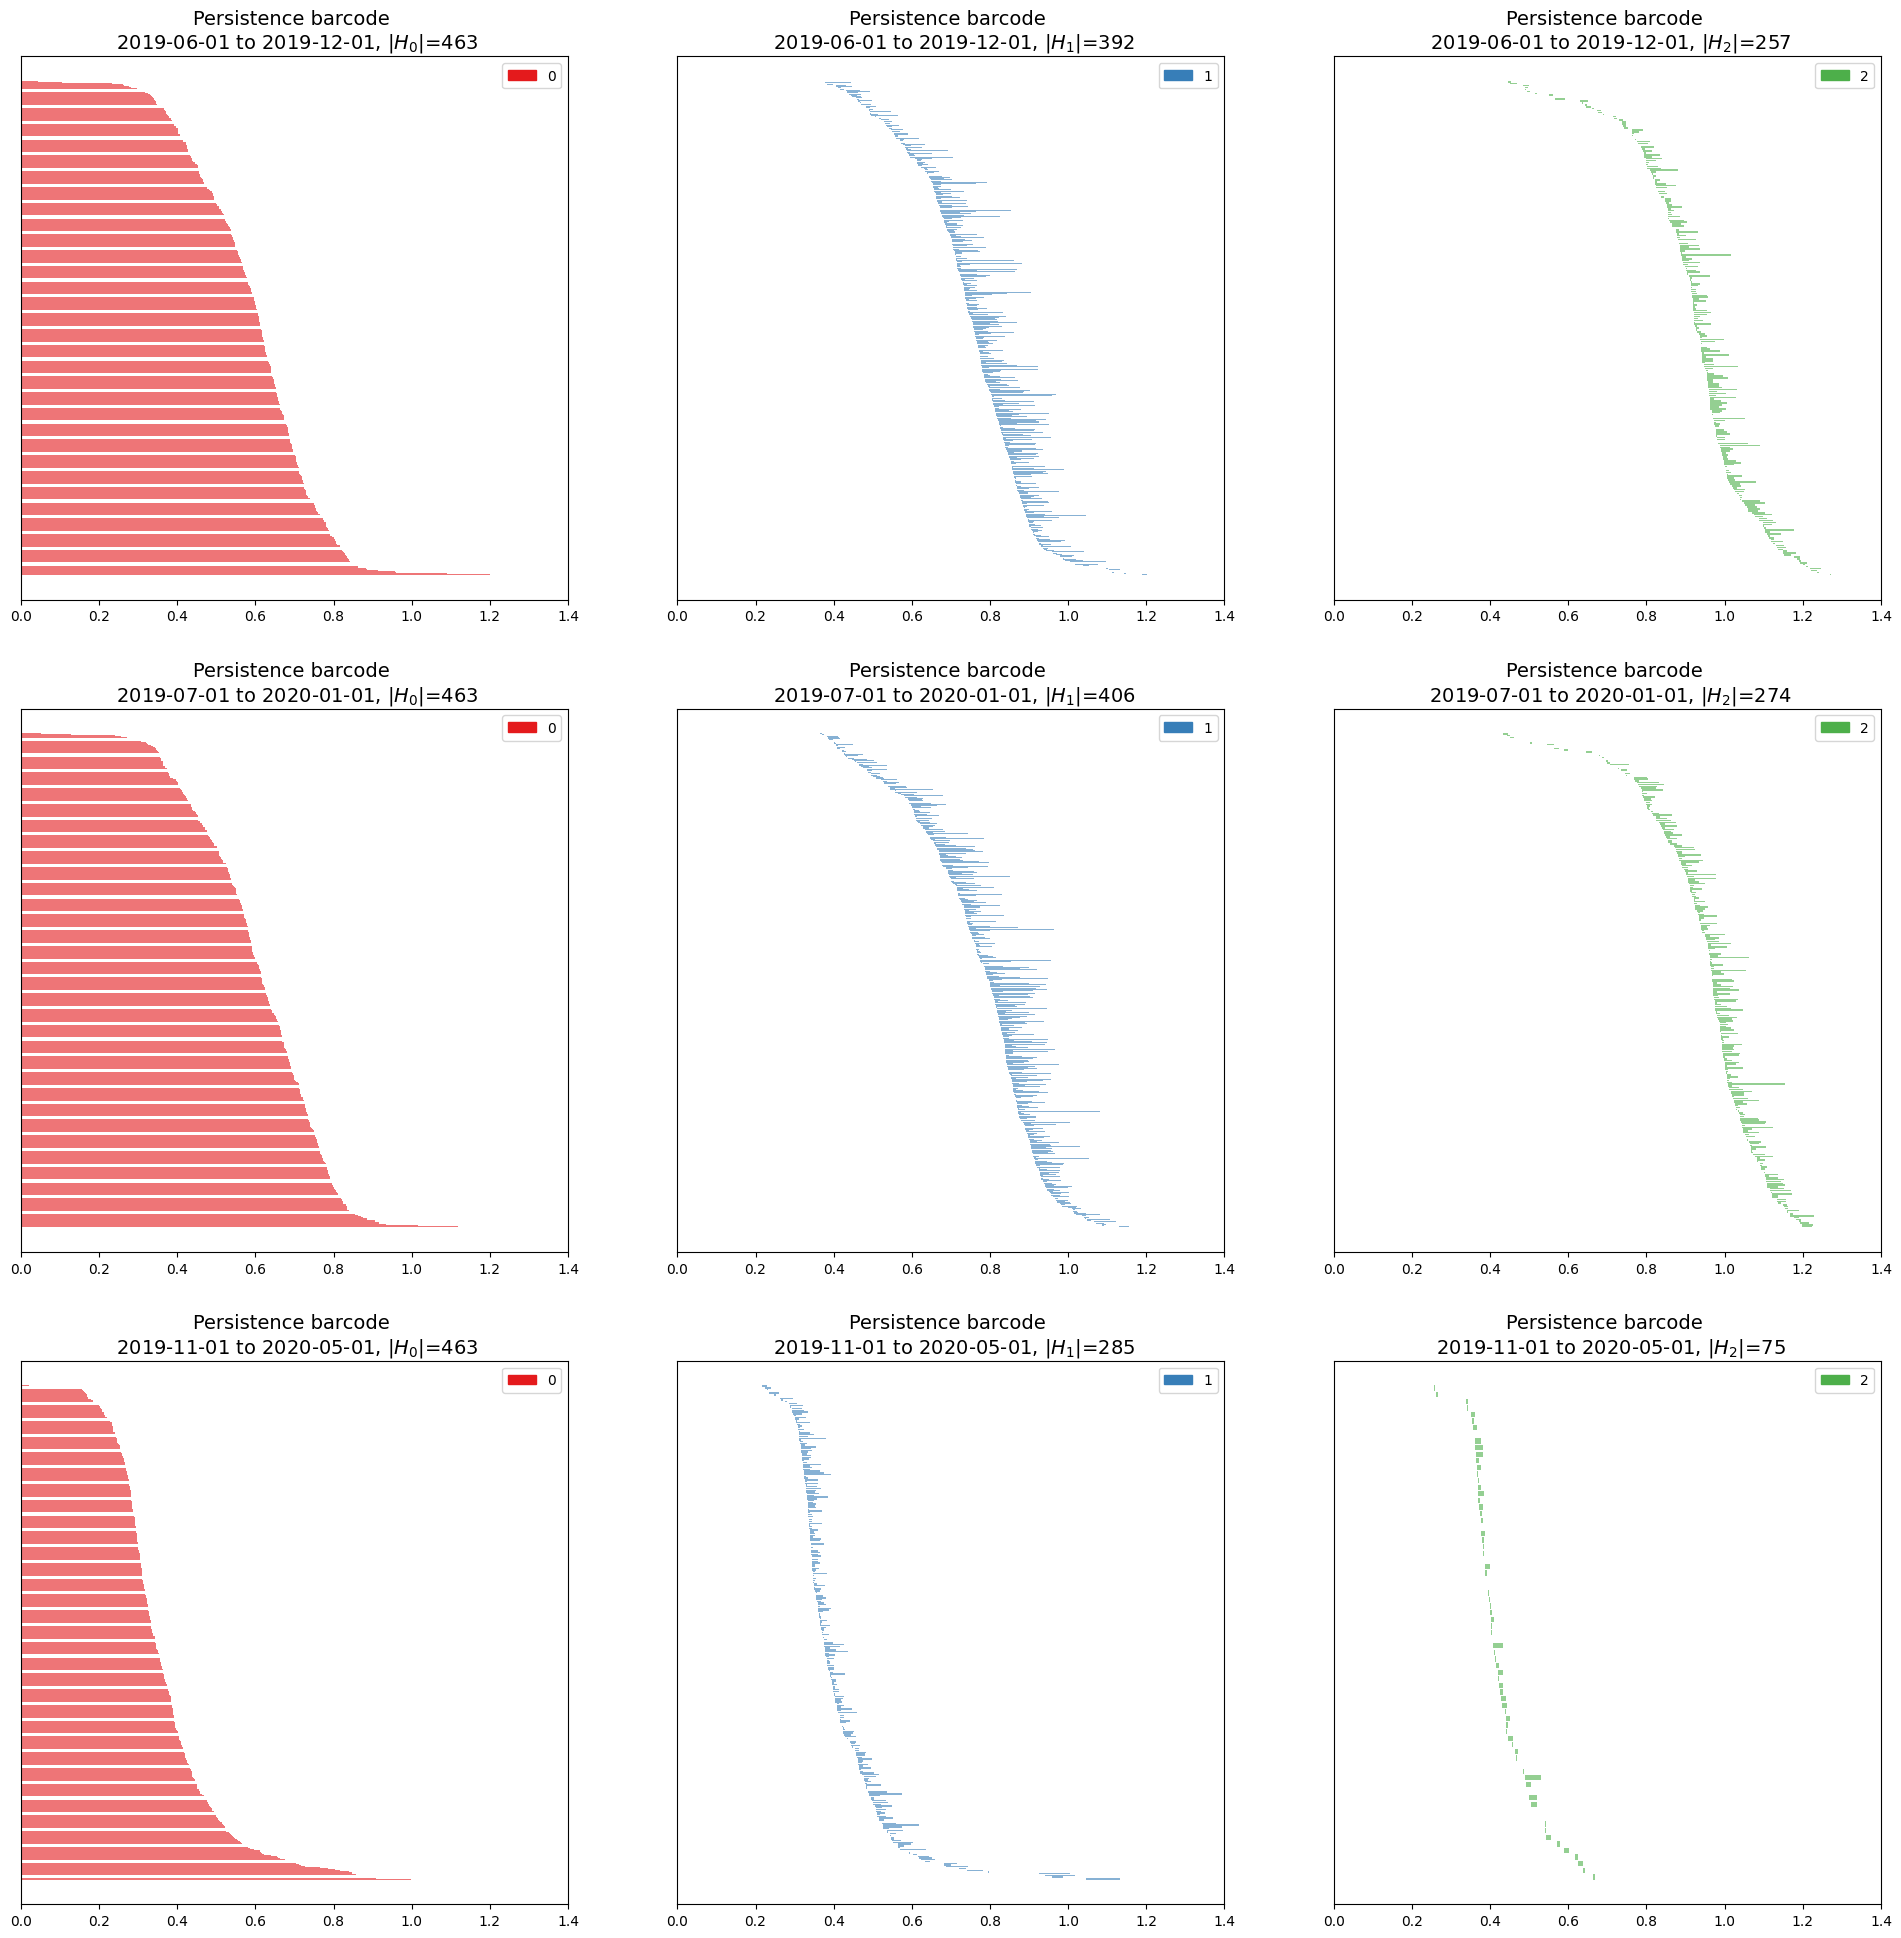

In [24]:
# Persistence weakening comparison of persistence barcode

start_dates = ['2019-06-01', '2019-07-01', '2019-11-01']

fig, axs = plt.subplots(3, 3, figsize=(24, 24))

for j, start_date_string in enumerate(start_dates):

    start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

    end_date = start_date + pd.DateOffset(months=6)

    data_6months = df[start_date:end_date]

    data_6months_corr = data_6months.corr()

    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']

    for dim in range(3):
        gd_barcode(barcode[dim], dim=dim, axes=axs[j, dim])

        axs[j, dim].set_xlim(0, 1.4)
        axs[j, dim].set_title(f"Persistence barcode \n {str(start_date).split()[0]} to {str(end_date).split()[0]}, $|H_{dim}|$={len(barcode[dim])}", fontsize = 14)        

        

In [25]:
df_comp = df_entropy.loc[['2019-06-01 to 2019-12-01', '2019-07-01 to 2020-01-01', '2019-11-01 to 2020-05-01']]

In [26]:
print(df_comp.to_latex())

\begin{tabular}{lrrr}
\toprule
 & $\beta_0$ & $\beta_1$ & $\beta_2$ \\
Period &  &  &  \\
\midrule
2019-06-01 to 2019-12-01 & 6.104755 & 5.571578 & 5.183860 \\
2019-07-01 to 2020-01-01 & 6.104176 & 5.657996 & 5.251413 \\
2019-11-01 to 2020-05-01 & 6.077547 & 5.289102 & 3.931646 \\
\bottomrule
\end{tabular}



In [27]:
df_entropy

,$\beta_0$,$\beta_1$,$\beta_2$
Period,,,
2019-06-01 to 2019-12-01,6.104755,5.571578,5.183860
2019-07-01 to 2020-01-01,6.104176,5.657996,5.251413
2019-08-01 to 2020-02-01,6.101148,5.584096,5.146555
2019-09-01 to 2020-03-01,6.091031,5.342686,4.482873
2019-10-01 to 2020-04-01,6.063672,5.219185,4.073322
2019-11-01 to 2020-05-01,6.077547,5.289102,3.931646
2019-12-01 to 2020-06-01,6.074272,5.304752,4.326869
2020-01-01 to 2020-07-01,6.075670,5.321382,4.463198
2020-02-01 to 2020-08-01,6.071353,5.355598,4.384561
